## Degraded Broadcast Channel Demo

Author: Cheuk Ting Li  

In [1]:
from psitip import *
PsiOpts.setting(solver = "pyomo.glpk")     # Set linear programming solver
PsiOpts.setting(repr_latex = True)         # Jupyter Notebook LaTeX display
PsiOpts.setting(venn_latex = True)         # LaTeX in diagrams
PsiOpts.setting(proof_note_color = "blue") # Reasons in proofs are blue

In [2]:
X, Y, Z, U = rv("X, Y, Z, U")
M1, M2 = rv_array("M", 1, 3)
R1, R2 = real_array("R", 1, 3)

model = CodingModel()
model.set_rate(M1, R1)    # Rate of M1 is R1
model.set_rate(M2, R2)    # Rate of M2 is R2
model.add_node(M1+M2, X,
          label = "Enc")  # Encoder maps M1,M2 to X
model.add_edge(X, Y)      # Channel X -> Y -> Z
model.add_edge(Y, Z)
model.add_node(Y, M1,
        label = "Dec 1")  # Decoder 1 maps Y to M1
model.add_node(Z, M2,
        label = "Dec 2")  # Decoder 2 maps Z to M2

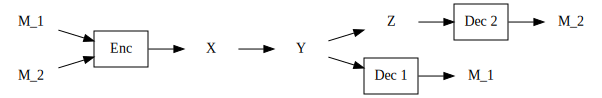

In [3]:
model.graph()             # Draw diagram

In [4]:
# Inner bound via [Lee-Chung 2015], give superposition region [Bergmans 1973], [Gallager 1974]
r = model.get_inner()
r

( ( R_1 >= 0 )
 &( R_2 >= 0 )
 &( R_2 <= I(A_M_2&Z) )
 &( R_1+R_2 <= I(A_M_2&Z)+I(X&Y|A_M_2) )
 &( markov(A_M_2, X, Y, Z) ) ).exists(A_M_2)

In [5]:
# Alternative characterization of superposition region
r2 = alland([
    R1 >= 0, R2 >= 0,
    R1 <= I(X & Y | U),
    R2 <= I(U & Z),
    markov(U, X, Y, Z)
]).exists(U)
r2

( ( R_1 >= 0 )
 &( R_2 >= 0 )
 &( R_1 <= I(X&Y|U) )
 &( R_2 <= I(U&Z) )
 &( markov(U, X, Y, Z) ) ).exists(U)

In [6]:
# Prove that they are the same
print(bool(r >> r2))  # r implies r2
print(bool(r2 >> r))  # r2 implies r

True
True


In [7]:
r.maximum(R1 + R2, [R1, R2])          # Max sum rate

(markov(X, Y, Z) ).maximum(I(X&Y))

In [8]:
r.maximum(emin(R1, R2), [R1, R2])     # Max symmetric rate

(( ( max79704(emin(R_1, R_2)) <= I(A_M_2&Z) )
 &( 2*max79704(emin(R_1, R_2)) <= I(A_M_2&Z)+I(X&Y|A_M_2) )
 &( markov(A_M_2, X, Y, Z) ) ).exists(A_M_2)).maximum(max79704(emin(R_1, R_2)))

In [9]:
r.maximum(R1 / 2 + R2, [R1, R2])      # Max weighted sum rate

(( ( markov(A_M_2, X, Y, Z) ) ).exists(A_M_2)).maximum((I(A_M_2&Z)+(1/2)*I(X&Y|A_M_2)))

In [10]:
r.exists(R1)   # Eliminate R1, same as r.projected(R2)

( ( R_2 >= 0 )
 &( R_2 <= I(X&Z) )
 &( markov(X, Y, Z) ) )

In [11]:
# Eliminate Z, i.e., taking union of the region over all choices of Z
# The program correctly deduces that it suffices to consider Z = Y
r.exists(Z).simplified()

( ( R_1 >= 0 )
 &( R_2 >= 0 )
 &( R_1+R_2 <= I(X&Y) ) )

------
### Outer Bound and Tightness

In [12]:
# Automatic outer bound with 1 auxiliary, gives superposition region
model.get_outer(1)

( ( R_1 >= 0 )
 &( R_2 >= 0 )
 &( R_2 <= I(A&Z) )
 &( R_1 <= I(X&Y|A) )
 &( markov(A, X, Y, Z) ) ).exists(A)

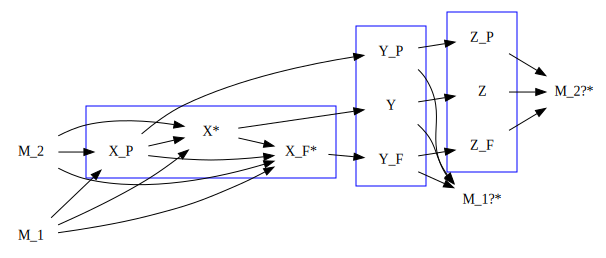

In [13]:
model.graph_outer()       # Bayesian network of past/future variables

In [14]:
# Converse proof, print auxiliary random variables
(model.get_outer() >> r).check_getaux_array()

CompArray(
[[A_M_2, Y_P+M_2]])

In [15]:
# Output converse proof (is_proof = True for shorter proof)
(model.get_outer(is_proof = True) >> r).proof()

------
### Manual Definition of Coding Setting

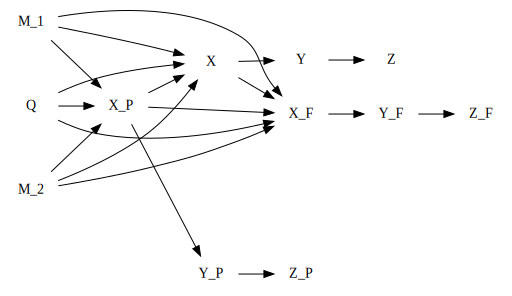

In [16]:
# If the above automated definition of random variables is not desired,
# it is possible to define the setting manually

X = rv_series("X")  # Define past/current/future RV of X
Y = rv_series("Y")  # Each rv_series contains 3 RVs: past, present, future
Z = rv_series("Z")
Q = rv("Q")         # Time sharing RV

M1, M2 = rv_array("M", 1, 3)
R1, R2 = real_array("R", 1, 3)
eps = real("eps", latex = "\epsilon")  # Gap term of rate

# The past/current/future/all of X are given by
# X["P"] / X[0] or X["C"] / X["F"] / X["A"] resp.

# Bayesian network of past/current/future RVs
bn = bnet(
    (M1+M2+Q, X["A"]), (X["P"], Y["P"], Z["P"]),
    (X[0], Y[0], Z[0]), (X["F"], Y["F"], Z["F"])
)
bn.assume()  # Assume Bayesian network is true in global scope
display(bn)  # Draw Bayesian network

# Assume Csiszar sum identity holds in global scope
csiszar_sum(X, Y, Z, M1, M2, timerv = Q).assume()

# Since M1, M2 are independent, we have I(M1;M2;T|T_P)<=0 for any T
# Enumerate subsets of {X,Y,Z} (i.e., empty, X, Y, Z, X+Y, X+Z, Y+Z, X+Y+Z)
for T in CompArray([X, Y, Z]).subsets():
    (I(M1 & M2 & T[0] | T["P"]) <= 0).assume()

(I(M1 & Y[0] | Y["P"]) >= R1 - eps).assume()  # Rate of M1
(I(M2 & Z[0] | Z["P"]) >= R2 - eps).assume()  # Rate of M2

U = M2 + Y["P"]  # Choice of auxiliary

# Prove the outer bound
display((R2 <= I(U & Z[0] | Q) + eps).proof())
display((R1+R2 <= I(U & Z[0] | Q) + I(X[0] & Y[0] | U+Q) + eps * 2).proof())

universe().assume_only()  # Clear all assumptions

### References
- A. El Gamal and Y.-H. Kim, _Network Information Theory_, Cambridge University Press, 2011, Ch. 5.
- P. Bergmans, "Random coding theorem for broadcast channels with degraded components," IEEE Transactions on Information Theory, vol. 19, no. 2, pp. 197–207, 1973.
- R. G. Gallager, "Capacity and coding for degraded broadcast channels," Problemy Peredachi Informatsii, vol. 10, no. 3, pp. 3–14, 1974.
- J. Körner and K. Marton, "Images of a set via two channels and their role in multi-user communication," IEEE Trans. Inf. Theory, vol. 23, no. 6, pp. 751–761, 1977.
- I. Csiszár and J. Körner, "Broadcast channels with confidential messages," IEEE Trans. Inf. Theory, vol. 24, no. 3, pp. 339–348, 1978.